# 01_sampling.ipynb

Here, we inspect sampling methodologies we want to use for our algorithm grid search and evaluation to decrease the bias of our results. We'll mainly focus on terrain and LULc considerations.

TODO: spatial autocorrelation?

In [73]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import sliderule
from sliderule import icesat2, earthdata
import matplotlib as mpl
import easysnowdata as esd
from tqdm import tqdm
import pandas as pd
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from datetime import timedelta
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import pystac_client
import planetary_computer
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import odc.stac
import xdem
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import sys
sys.path.append('..')
from misc.nlcd_plot import nlcd_colors, nlcd_labels
%matplotlib inline

In [2]:
# load in our same sites of interest data
cols = ['3dep_workunit', '3dep_workunit_id', '3dep_start_datetime', 
        '3dep_end_datetime', '3dep_duration', 'fourway_overlap_area_km2',
        'geometry']
gf_sites_4326 = gpd.read_file("../data/PCD_3dep_sites_feb_2025.geojson")[cols]

In [156]:
# and let's isolate one site to use as an example for visualization purposes
# i cherry picked one with forest vegetation for demonstrative purposes
gf_search = gf_sites_4326.iloc[[19]]

In [157]:
# and let's bring in our same example ICESat-2 data from 00_dataset_intro.ipynb
poly_sliderule = sliderule.toregion(gf_search)['poly']
geojson = earthdata.tnm(short_name='Digital Elevation Model (DEM) 1 meter', 
                        polygon=poly_sliderule)
start = (gf_search['3dep_start_datetime'].item() - timedelta(days=14)).strftime('%Y-%m-%dT%H:%M:%SZ')
end = (gf_search['3dep_end_datetime'].item() + timedelta(days=14)).strftime('%Y-%m-%dT%H:%M:%SZ')
# default ATL06 parms
parms = {
    "poly": poly_sliderule,
    "t0": start,
    "t1": end,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "samples": {"3dep": {"asset": "usgs3dep-1meter-dem"}}
    }
%time
atl06 = icesat2.atl06p(parms,
                       keep_id=True)
print("Reference Ground Tracks: {}".format(atl06["rgt"].unique()))
print("Cycles: {}".format(atl06["cycle"].unique()))
print("Received {} elevations".format(len(atl06)))

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 16 μs
Reference Ground Tracks: [1124]
Cycles: [10]
Received 11874 elevations


In [158]:
# extract the 3dep elevation values from the wonky data structure
atl06['3dep_elev'] = atl06['3dep.value'].apply(lambda x: x[1] if isinstance(x, (list, np.ndarray)) and len(x) > 1 else None)
# now add our elevation differences to 'ground truth' or our 3DEP samples
atl06["elev_diff"] = atl06["h_mean"] - atl06['3dep_elev']

Now, let's bring in some additional contextual data to help understand potential biases and confounding variables. We'll just focus on elevation characteristics, LULC, and an image of the scene for now.

To do this we'll use the COP30 DEM for just a general elevation check, NLCD LULC, and a Sentinel-2 RGB composite

In [159]:
# let's grab that cop30 DEM
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects=gf_search.geometry.item().__geo_interface__)
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 4 Items


In [160]:
%%time
bounds = gf_search.total_bounds
swaths = []
for item in items:
    dem_path = planetary_computer.sign(item.assets['data']).href
    clipped = rxr.open_rasterio(
        dem_path, 
        chunks={'x': 1024, 'y': 1024}
    ).rio.clip_box(*bounds)
    swaths.append(clipped.rename('elevation'))
ds_cop30 = xr.merge(swaths).compute()
ds_cop30 = ds_cop30.rio.reproject(atl06.crs)

CPU times: user 4.28 s, sys: 712 ms, total: 5 s
Wall time: 34.5 s


In [161]:
# and let's get some hillshade data for our viz
hillshade = xdem.terrain.hillshade(
    dem=ds_cop30.elevation.squeeze(),
    resolution=(30, 30),
)
da_hillshade = xr.DataArray(
    hillshade,
    dims=['y', 'x'],
    coords={
        'y': ds_cop30.y,
        'x': ds_cop30.x
    }
)
ds_cop30['hillshade'] = da_hillshade.expand_dims('band')

In [162]:
# great! now let's move onto NLCD like we did in 00_dataset_intro.ipynb
da_nlcd = esd.remote_sensing.get_nlcd_landcover(gf_search, layer='landcover')
da_nlcd = da_nlcd.rio.reproject(atl06.crs)

In [166]:
# that was easy! let's move onto a 'true color' image from around the time of interest
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)
search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=gf_search.geometry.item(),
        datetime=f'2021-03-06/2021-05-08')
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 75 Items


In [167]:
# isolate the image with the lowest cloud cover percentage
# not sure if output_crs should just be 7912 or 4326->reproject
sentinel2_stac = odc.stac.load(items,chunks={"x": 2048, "y": 2048},
                               resolution=10, groupby='solar_day')
minx, miny, maxx, maxy = gf_search.geometry[19].bounds
sentinel2_stac_clipped = sentinel2_stac.rio.clip_box(minx, miny, maxx, maxy, 
                                                     crs="EPSG:4326")
scl = sentinel2_stac_clipped["SCL"]
cloud_classes = [8, 9, 10]
idx_least_clouds = scl.where(~scl.isin(cloud_classes)).sum(dim=['x','y']).idxmax()
sentinel2_best = sentinel2_stac_clipped.sel(time=idx_least_clouds)
cloud_coverage = [item.properties.get('eo:cloud_cover', 100) for item in items]
best_idx = np.argmin(cloud_coverage)
best_datetime = items[best_idx].datetime
print(f"Selected image datetime: {best_datetime}")

Selected image datetime: 2021-03-30 15:35:51.024000+00:00


In [168]:
# stack the RGB bands
rgb = np.dstack([
    sentinel2_best.B04.compute(),
    sentinel2_best.B03.compute(),
    sentinel2_best.B02.compute()
])
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
# and brighten the image so it's easier to visually interpret
gamma = 0.5  
rgb_bright = np.power(rgb_norm, gamma)
# and turn into an xarray da with CRS information
da_rgb = xr.DataArray(
    np.moveaxis(rgb_bright, -1, 0),  # move band dimension to front
    dims=['band', 'y', 'x'],
    coords={
        'band': ['red', 'green', 'blue'],
        'y': sentinel2_best.y,
        'x': sentinel2_best.x
    }
).rio.write_crs(sentinel2_best.rio.crs).rio.reproject(atl06.crs)

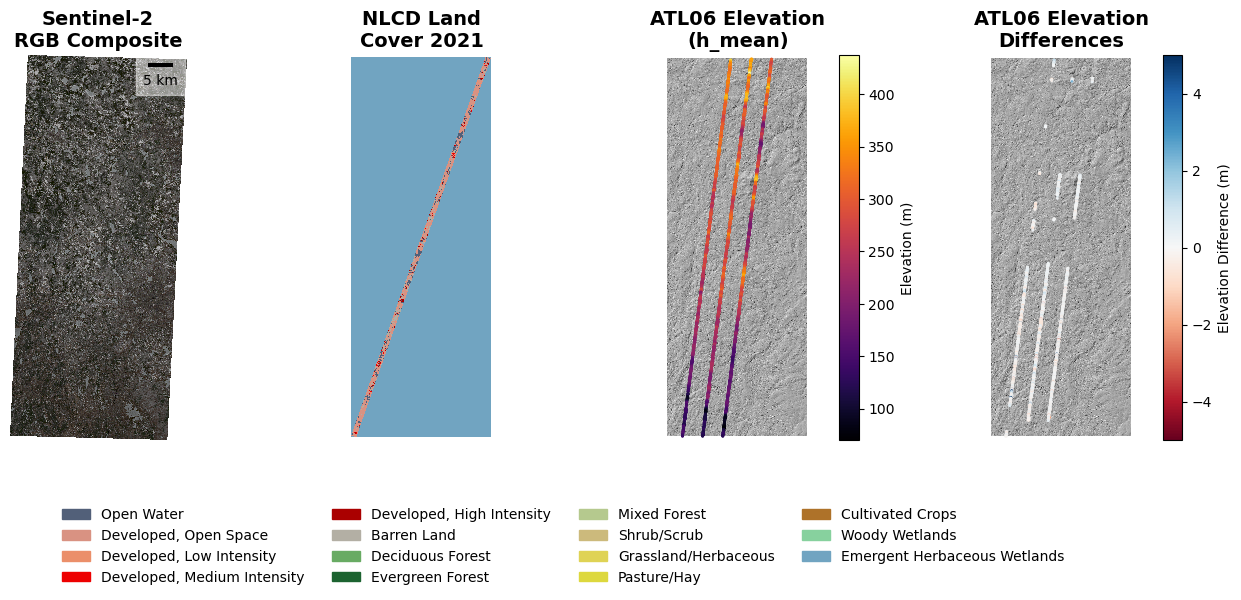

In [170]:
f, axs = plt.subplots(1,4,figsize=(16, 5),
                      sharex=True, sharey=True)

# Sentinel-2 RGB
# --------------------------
ax=axs[0]
da_rgb.plot.imshow(ax=ax)
scalebar = ScaleBar(
    1e5,
    "m",    
    length_fraction=.25,
    location="upper right",
    box_alpha=0.5,
    box_color="white",
    color="black",        
    pad=0.5,
    frameon=True
)
ax.add_artist(scalebar)
ax.set_title("Sentinel-2\nRGB Composite",
             fontweight="bold", fontsize=14)

# NLCD
# --------------------------
ax = axs[1]
da_nlcd.plot.imshow(ax=ax, 
                    cmap=mcolors.ListedColormap([nlcd_colors[i] for i in sorted(nlcd_colors.keys())]),
                    add_colorbar=False)
ax.set_title("NLCD Land\nCover 2021", fontweight="bold", fontsize=14)
present_classes = np.unique(da_nlcd.values[~np.isnan(da_nlcd.values)])
legend_handles = [
    mpatches.Patch(
        color=nlcd_colors[key],
        label=nlcd_labels[key]
    )
    for key in sorted(nlcd_colors.keys())
    if key in present_classes
]
f.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, 0),
    loc='upper center',
    ncol=4,
    frameon=False,
    fontsize=10
)

# ATL06 h_mean
# --------------------------
ax=axs[2]
ds_cop30.hillshade.squeeze().plot.imshow(ax=ax,
                                         cmap="gray",
                                         add_colorbar=False)
atl06.plot(ax=ax, column="h_mean", cmap='inferno', 
           alpha=0.5, s=1, legend=True,
           legend_kwds={'label': 'Elevation (m)'})
ax.set_title("ATL06 Elevation\n(h_mean)", fontweight="bold", fontsize=14)

# ATL06 elevation difference
# --------------------------
ax=axs[3]
ds_cop30.hillshade.squeeze().plot.imshow(ax=ax,
                                         cmap="gray",
                                         add_colorbar=False)
atl06.plot(ax=ax, column="elev_diff", cmap='RdBu', 
           alpha=0.5, s=1, legend=True, vmin=-5, vmax=5,
           legend_kwds={'label': 'Elevation Difference (m)'})
ax.set_title("ATL06 Elevation\nDifferences", fontweight="bold", fontsize=14)

# final formatting
# ---------------------------
for ax in axs:
    ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)
    ax.set_aspect("equal");

In [ ]:
# TODO: fix NLCD call and example plot

In [ ]:
# TODO: elevation difference hists over vegetation

In [ ]:
# TODO: diff hists for slope, confounding varibale

In [ ]:
# TODO: actual sampling techniques